In [1]:
import numpy as np
import pandas as pd
import os

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20M Jan 15 18:18 data/kultura.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 

In [2]:
name_dataset = 'Sil_struktur'

### load data

In [3]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(31361, 7)
CPU times: user 4.7 s, sys: 25.2 ms, total: 4.73 s
Wall time: 4.74 s


In [4]:
df = df[df.text!='text']
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/skuratov/,NaN,Россия,Cледствие по делу Скуратова продлено еще на 4 ...,Генеральная прокуратура продлила еще на 4 меся...,Силовые структуры
1,1999-10-04 12:00:00,https://lenta.ru/news/1999/10/04/bank_skandal/,NaN,Россия,Зять Ельцина вызван на допрос,Зять президента Ельцина Леонид Дьяченко вызван...,Силовые структуры


### preprocess

* get dates

In [5]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

CPU times: user 125 ms, sys: 0 ns, total: 125 ms
Wall time: 124 ms


<unknown>:2: DeprecationWarning: invalid escape sequence \d


* clean text

In [6]:
import preprocessing_tools as pr

In [7]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 5.28 s, sys: 19.3 ms, total: 5.3 s
Wall time: 5.3 s


In [8]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/skuratov/,NaN,Россия,Cледствие по делу Скуратова продлено еще на 4 ...,генеральная прокуратура продлила еще на месяц...,Силовые структуры,"[(1999, 10, 01)]",1999,10
1,1999-10-04 12:00:00,https://lenta.ru/news/1999/10/04/bank_skandal/,NaN,Россия,Зять Ельцина вызван на допрос,зять президента ельцина леонид дьяченко вызван...,Силовые структуры,"[(1999, 10, 04)]",1999,10


* cleanedNames

In [9]:
from cleanedNames import KeyProc
cn = KeyProc()

In [10]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 55.4 s, sys: 0 ns, total: 55.4 s
Wall time: 55.4 s


* lemmatization

In [11]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 1min 31s, sys: 89 ms, total: 1min 31s
Wall time: 1min 31s


* add docID

In [12]:
df['docID'] = list(range(df.shape[0]))

In [13]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,1999,10,"[генеральный, прокуратура, продлить, месяцасро..."
1,1,1999,10,"[зять, ельцин, леонид, дьяченко, вызвать, допр..."


In [14]:
print(df.shape)
df.isnull().sum()

(31361, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [15]:
df.year.min()

1999

## model

* prepare

In [16]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 402 ms, sys: 40 ms, total: 442 ms
Wall time: 472 ms


In [17]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [18]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

artm.BatchVectorizer(data_path="data/batches/Sil_struktur", num_batches=32)
CPU times: user 14 s, sys: 632 ms, total: 14.6 s
Wall time: 3.9 s


In [19]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [20]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=c7deb880-2c63-45c5-afda-a653c3140e8e, num_entries=16166)

In [22]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [23]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

for i in range(2,20+1,1):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

    # regularizers
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)
    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)
    
newTime = time.now() #

#topic 2.........
	SparsityThetaScore: 0.15396511554718018
	SparsityPhiScore: 0.2677534818649292
	PerplexityScore: 3653.285400390625
	time: 0:00:36.352812
#topic 3.........
	SparsityThetaScore: 0.2911684215068817
	SparsityPhiScore: 0.40097156167030334
	PerplexityScore: 3289.565185546875
	time: 0:00:39.150514
#topic 4.........
	SparsityThetaScore: 0.3634689450263977
	SparsityPhiScore: 0.49238914251327515
	PerplexityScore: 3062.85400390625
	time: 0:00:41.069785
#topic 5.........
	SparsityThetaScore: 0.43693122267723083
	SparsityPhiScore: 0.5417808890342712
	PerplexityScore: 2911.385498046875
	time: 0:00:42.792404
#topic 6.........
	SparsityThetaScore: 0.4823719561100006
	SparsityPhiScore: 0.5858548283576965
	PerplexityScore: 2801.00537109375
	time: 0:00:45.509098
#topic 7.........
	SparsityThetaScore: 0.5203551054000854
	SparsityPhiScore: 0.6210148334503174
	PerplexityScore: 2687.305908203125
	time: 0:00:48.220750
#topic 8.........
	SparsityThetaScore: 0.5667309761047363
	SparsityPhiScor

In [31]:
#model_list

Text(0.5, 1.0, 'SparsityPhiScore')

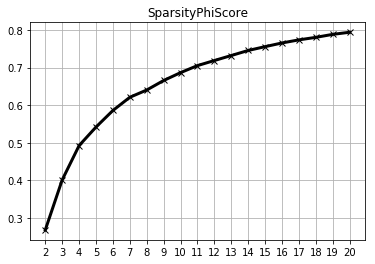

In [33]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [34]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.2, 0.4, 0.5, 0.6, 0.7]

In [35]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.2: 1, 0.4: 2, 0.5: 2, 0.6: 4, 0.7: 10}

Text(0.5, 1.0, 'SparsityThetaScore')

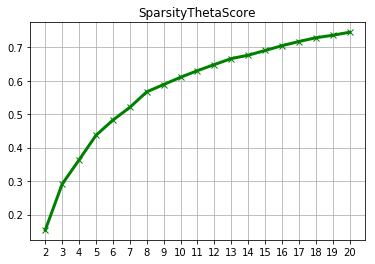

In [36]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [37]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [38]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.1: 1, 0.2: 1, 0.3: 1, 0.4: 2, 0.5: 3, 0.6: 6, 0.7: 5}

Text(0.5, 1.0, 'PerplexityScore')

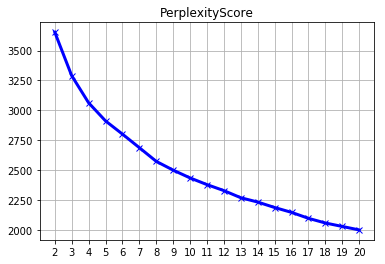

In [39]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [40]:
perplexity

[3653.285400390625,
 3289.565185546875,
 3062.85400390625,
 2911.385498046875,
 2801.00537109375,
 2687.305908203125,
 2572.77734375,
 2499.46435546875,
 2434.17236328125,
 2378.302734375,
 2328.136962890625,
 2268.486083984375,
 2232.33935546875,
 2186.7275390625,
 2146.015625,
 2096.22265625,
 2057.16943359375,
 2028.176025390625,
 1999.2115478515625]

### select the best model

In [41]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

d_sphi:   {0.2: 1, 0.4: 2, 0.5: 2, 0.6: 4, 0.7: 10}
d_stheta: {0.1: 1, 0.2: 1, 0.3: 1, 0.4: 2, 0.5: 3, 0.6: 6, 0.7: 5}


In [42]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-2]
print(best_model.num_topics)

20


---

In [21]:
select_topics = 20

model = artm.ARTM(num_topics=select_topics, dictionary=dictionary, show_progress_bars=True)

# scores
model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# regularizers
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)

sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
perpl = model.score_tracker['PerplexityScore'].last_value

print(f'\tSparsityThetaScore: {sparsityTheta}')
print(f'\tSparsityPhiScore: {sparsityPhi}')
print(f'\tPerplexityScore: {perpl}')

best_model = model.clone()


	SparsityThetaScore: 0.7475702166557312
	SparsityPhiScore: 0.7928553819656372
	PerplexityScore: 2004.7174072265625


---

### print top words for each topics

In [22]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['заключённый' 'нарушение' 'фсин' 'завод' 'осудить' 'здание' 'наказание'
 'предприятие' 'площадь' 'изолятор']
topic_1: ['взятка' 'получение' 'полномочие' 'должностной' 'чиновник' 'должность'
 'отдел' 'превышение' 'доллар' 'служебный']
topic_2: ['изъять' 'наркотик' 'килограмм' 'вещество' 'обыск' 'боеприпас' 'оборот'
 'хранение' 'контрабанда' 'пистолет']
topic_3: ['министр' 'внутренний' 'закон' 'генпрокуратура' 'министерство' 'борьба'
 'новый' 'принять' 'прокурор' 'структура']
topic_4: ['военный' 'чечня' 'военнослужащий' 'чеченский' 'командир' 'войско'
 'офицер' 'полковник' 'батальон' 'воинский']
topic_5: ['чечня' 'операция' 'ингушетия' 'уничтожить' 'спецоперация' 'северный'
 'грозный' 'штаб' 'оперативный' 'вооружённый']
topic_6: ['хищение' 'мошенничество' 'банка' 'миллиард' 'фирма' 'ущерб' 'счёт'
 'доллар' 'банк' 'похитить']
topic_7: ['больница' 'полицейский' 'смерть' 'состояние' 'инцидент' 'здоровье'
 'скончаться' 'причинение' 'драка' 'водитель']
topic_8: ['санктпетербург' 'пе

In [34]:
# save to json

outjson = {}
# ---
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        #print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])
        outjson[f'{col}'] = phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:20]

In [35]:
import pickle

with open(f'''data/top20word/{'-'.join(name_dataset.split('.'))}.pickle''', 'wb') as handle:
    pickle.dump(outjson, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
with open(f'''data/top20word/{'-'.join(name_dataset.split('.'))}.pickle''', 'rb') as handle:
    out_picle = pickle.load(handle)
    
out_picle

{'topic_0': array(['заключённый', 'нарушение', 'фсин', 'завод', 'осудить', 'здание',
        'наказание', 'предприятие', 'площадь', 'изолятор', 'акция',
        'сизый', 'исполнение', 'беспорядок', 'учреждение', 'судно',
        'правило', 'административный', 'камера', 'исправительный'],
       dtype=object),
 'topic_1': array(['взятка', 'получение', 'полномочие', 'должностной', 'чиновник',
        'должность', 'отдел', 'превышение', 'доллар', 'служебный', 'скр',
        'злоупотребление', 'главный', 'мэр', 'сергей', 'вымогательство',
        'скп', 'мошенничество', 'занимать', 'особо'], dtype=object),
 'topic_2': array(['изъять', 'наркотик', 'килограмм', 'вещество', 'обыск',
        'боеприпас', 'оборот', 'хранение', 'контрабанда', 'пистолет',
        'оперативник', 'патрон', 'таможенный', 'сбыт', 'героин', 'грамм',
        'преступный', 'товар', 'найти', 'наркотический'], dtype=object),
 'topic_3': array(['министр', 'внутренний', 'закон', 'генпрокуратура', 'министерство',
        'бо

### get topics-docs matrix

shape theta: (20, 31361)


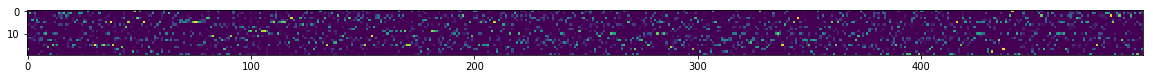

In [23]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [24]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
28000,0.672560,0.000000,0.000000,0.000000,0.0,0.113467,0.000000,0.199773,0.000000,0.000000,0.0,0.000000,0.0,0.0142,0.0,0.000000,0.0,0.0,0.0,0.0
28001,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.222252,0.000000,0.000000,0.0,0.704221,0.0,0.0000,0.0,0.073527,0.0,0.0,0.0,0.0
28002,0.170978,0.194410,0.000000,0.021451,0.0,0.000000,0.201983,0.047239,0.253604,0.058494,0.0,0.000000,0.0,0.0000,0.0,0.051841,0.0,0.0,0.0,0.0
28003,0.000000,0.000000,0.016141,0.925835,0.0,0.000000,0.000000,0.058024,0.000000,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0
28004,0.000000,0.680834,0.000000,0.000000,0.0,0.000000,0.231679,0.000000,0.000000,0.000000,0.0,0.087487,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0


## DataViz

In [25]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.0,0.056231,0.0,0.265510,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.319523,0.0,0.0,0.000000,0.000000,0.358736,0.00000,0.000000
1,1,1999,10,0.0,0.000000,0.0,0.201300,0.000000,0.000000,0.319422,...,0.000000,0.058697,0.028202,0.0,0.0,0.000000,0.000000,0.330902,0.01497,0.040099
2,2,1999,10,0.0,0.000000,0.0,0.218646,0.185032,0.573064,0.000000,...,0.023257,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
3,3,1999,10,0.0,0.000000,0.0,0.000000,0.000000,0.056317,0.052139,...,0.314725,0.089408,0.000000,0.0,0.0,0.289079,0.115489,0.000000,0.00000,0.000000
4,4,1999,10,0.0,0.038221,0.0,0.000000,0.000000,0.000000,0.500214,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.262852,0.00000,0.198712


In [26]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (228, 20)


topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  \
year month                                                               
1999 8      0.000000  0.000000  0.000000  0.831014  0.000000  0.000000   
     9      0.265757  0.474025  2.298231  4.395582  1.362000  3.917531   
     10     1.784275  1.314513  2.699699  9.148363  1.020612  1.481515   
     11     1.153909  1.313566  2.145489  7.705176  2.417216  2.569956   
     12     0.403437  1.550305  1.701292  5.641225  4.272182  4.137170   

             topic_6   topic_7   topic_8   topic_9  topic_10  topic_11  \
year month                                                               
1999 8      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
     9      0.782241  0.239790  0.118377  0.120196  4.987072  0.426346   
     10     4.091270  0.149838  0.482487  0.281479  1.615723  0.629520   
     11     2.449852  0.757369  1.302334  0.705005  1.617946  0.616938   
     12     1.219035  1.419068  0.504837  0.876672  1.796598  1.204243   

            topic_12  topic_13  topic_14  topic_15  topic_16  topic_17  \
year month                                                               
1999 8      0.000000  0.000000  0.168986  0.000000  0.000000  0.000000   
     9      0.275036  0.314258  1.438094  3.204786  0.036787  2.292804   
     10     1.439947  1.434370  2.927644  3.011850  0.709464  3.495656   
     11     1.717249  1.843889  3.547520  4.643814  1.422221  2.783428   
     12     1.860529  3.277558  2.359136  4.900120  1.406107  2.323799   

            topic_18  topic_19  
year month                      
1999 8      0.000000  0.000000  
     9      0.066250  0.984838  
     10     0.208871  1.072905  
     11     0.787592  1.499531  
     12     1.652241  2.494447

### straightforward matrix heatmap

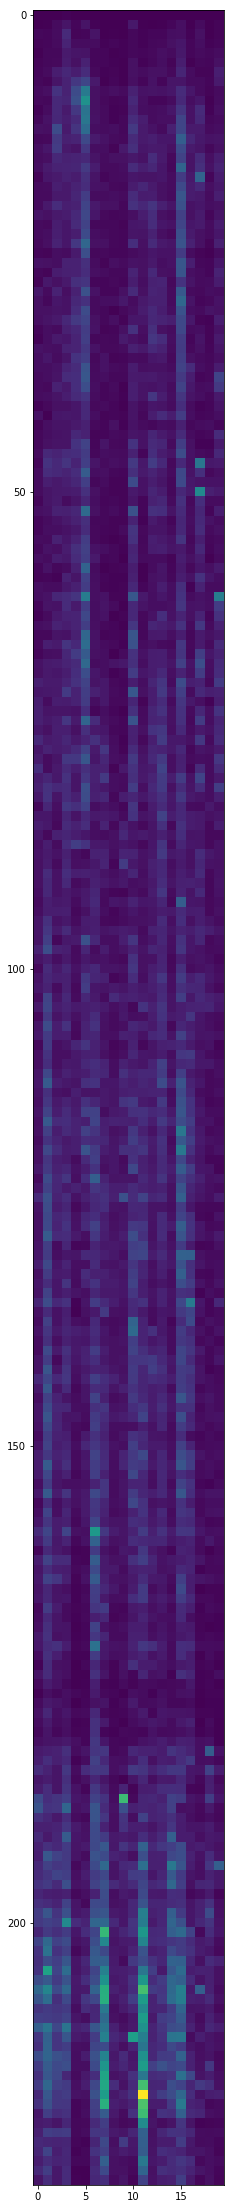

In [27]:
plt.figure(figsize=(10, 40))
plt.imshow(gb[topics])

## pygal

In [49]:
import pygal
from IPython.display import SVG, HTML

In [50]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [ ]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [52]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [53]:
import joypy # !pip install joypy

In [28]:
print(joined.shape)
joined.head()

(31361, 23)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.0,0.056231,0.0,0.265510,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.319523,0.0,0.0,0.000000,0.000000,0.358736,0.00000,0.000000
1,1,1999,10,0.0,0.000000,0.0,0.201300,0.000000,0.000000,0.319422,...,0.000000,0.058697,0.028202,0.0,0.0,0.000000,0.000000,0.330902,0.01497,0.040099
2,2,1999,10,0.0,0.000000,0.0,0.218646,0.185032,0.573064,0.000000,...,0.023257,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
3,3,1999,10,0.0,0.000000,0.0,0.000000,0.000000,0.056317,0.052139,...,0.314725,0.089408,0.000000,0.0,0.0,0.289079,0.115489,0.000000,0.00000,0.000000
4,4,1999,10,0.0,0.038221,0.0,0.000000,0.000000,0.000000,0.500214,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.262852,0.00000,0.198712


In [29]:
joined.to_csv(f'./data/topicsProbability/{name_dataset}.csv',index=False)

In [55]:
joined['year_month'] = joined.apply(lambda x: str(int(x.year)) +'-'+ str(int(x.month)) + '-01', axis=1)
joined.reset_index(inplace=True)

joined.head()

,index,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,year_month
0,0,0,1999,10,0.0,0.043748,0.000000,0.325234,0.000000,0.000000,...,0.000000,0.242394,0.0,0.0,0.000000,0.00000,0.388624,0.0,0.000000,1999-10-01
1,1,1,1999,10,0.0,0.000000,0.000000,0.154981,0.000000,0.000000,...,0.053226,0.019143,0.0,0.0,0.000000,0.00000,0.266540,0.0,0.051709,1999-10-01
2,2,2,1999,10,0.0,0.000000,0.000000,0.236952,0.082387,0.645179,...,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,1999-10-01
3,3,3,1999,10,0.0,0.000000,0.012173,0.000000,0.000000,0.022984,...,0.050846,0.000000,0.0,0.0,0.287309,0.14004,0.000000,0.0,0.000000,1999-10-01
4,4,4,1999,10,0.0,0.040796,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.078137,0.0,0.346197,1999-10-01


In [56]:
joined_melt = joined.melt('year_month', var_name='topic', value_name='text')
print(joined_melt.shape)
joined_melt.head()

(752664, 3)


,year_month,topic,text
0,1999-10-01,index,0.0
1,1999-10-01,index,1.0
2,1999-10-01,index,2.0
3,1999-10-01,index,3.0
4,1999-10-01,index,4.0


In [57]:
# select only topic_*
joined_melt_new = joined_melt[(joined_melt.topic!='docID') & (joined_melt.topic!='index')
                              & (joined_melt.topic!='year') & (joined_melt.topic!='month')]
print(joined_melt_new.shape)
joined_melt_new.topic.value_counts()

(627220, 3)


topic_14    31361
topic_0     31361
topic_11    31361
topic_15    31361
topic_10    31361
topic_9     31361
topic_6     31361
topic_13    31361
topic_4     31361
topic_17    31361
topic_16    31361
topic_5     31361
topic_3     31361
topic_18    31361
topic_1     31361
topic_2     31361
topic_19    31361
topic_12    31361
topic_8     31361
topic_7     31361
Name: topic, dtype: int64

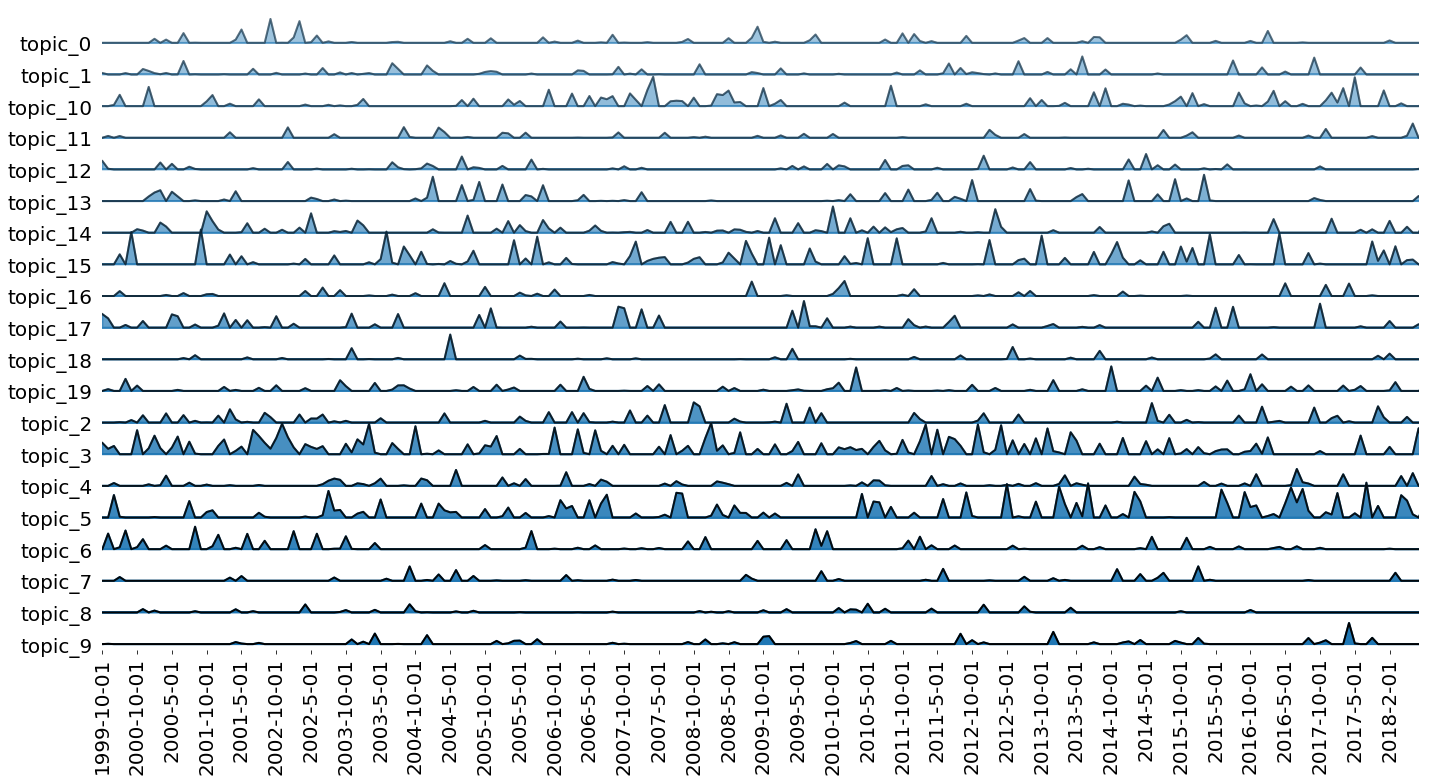

In [58]:
labels = sorted(joined_melt_new['year_month'].unique())

fig, axes = joypy.joyplot(joined_melt_new, by='topic', column='text', figsize=(20, 10),xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True, linecolor="k", linewidth=2,
                          kind='values', fade=True, xrot=90, x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [59]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")